Building 3D phantom using TomoPhantom software
Phantom has been built in 0.6699983458966017 seconds


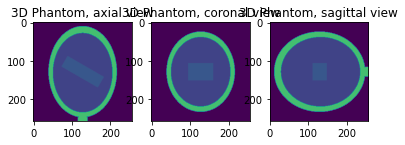

In [4]:
import timeit
import os
import matplotlib.pyplot as plt
import numpy as np
import tomophantom
from tomophantom import TomoP3D
from tomophantom.supp.qualitymetrics import QualityTools
from tomophantom.supp.flatsgen import synth_flats
from tomobar.supp.suppTools import normaliser

print ("Building 3D phantom using TomoPhantom software")
tic=timeit.default_timer()
model = 17 # select a model number from the library
N_size = 256 #512 # Define phantom dimensions using a scalar value (cubic phantom)
path = os.path.dirname(tomophantom.__file__)
path_library3D = os.path.join(path, "Phantom3DLibrary.dat")
#This will generate a N_size x N_size x N_size phantom (3D)
phantom_tm = TomoP3D.Model(model, N_size, path_library3D)
toc=timeit.default_timer()
Run_time = toc - tic
print("Phantom has been built in {} seconds".format(Run_time))

sliceSel = int(0.5*N_size)
#plt.gray()
plt.figure() 
plt.subplot(131)
plt.imshow(phantom_tm[sliceSel,:,:],vmin=0, vmax=1)
plt.title('3D Phantom, axial view')

plt.subplot(132)
plt.imshow(phantom_tm[:,sliceSel,:],vmin=0, vmax=1)
plt.title('3D Phantom, coronal view')

plt.subplot(133)
plt.imshow(phantom_tm[:,:,sliceSel],vmin=0, vmax=1)
plt.title('3D Phantom, sagittal view')
plt.show()

# Projection geometry related parameters:
Horiz_det = N_size # int(np.sqrt(2)*N_size) # detector column count (horizontal)
Vert_det = N_size # detector row count (vertical) (no reason for it to be > N)
angles_num = 1024 # int(0.5*np.pi*N_size); # angles number
angles = np.linspace(0.0,179.9,angles_num,dtype='float32') # in degrees
angles_rad = angles*(np.pi/180.0)

Building 3D analytical projection data with TomoPhantom


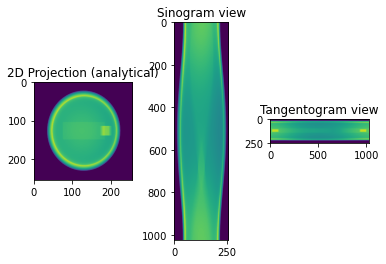

In [5]:
print ("Building 3D analytical projection data with TomoPhantom")
projData3D_analyt = TomoP3D.ModelSino(model, N_size, Horiz_det, Vert_det, angles, path_library3D)

intens_max_clean = np.max(projData3D_analyt)
sliceSel = 150
plt.figure() 
plt.subplot(131)
plt.imshow(projData3D_analyt[:,sliceSel,:],vmin=0, vmax=intens_max_clean)
plt.title('2D Projection (analytical)')
plt.subplot(132)
plt.imshow(projData3D_analyt[sliceSel,:,:],vmin=0, vmax=intens_max_clean)
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData3D_analyt[:,:,sliceSel],vmin=0, vmax=intens_max_clean)
plt.title('Tangentogram view')
plt.show()

Simulate synthetic flat fields, add flat field background to the projections and add noise


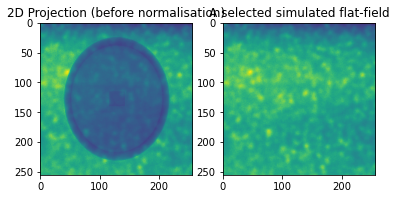

In [6]:
print ("Simulate synthetic flat fields, add flat field background to the projections and add noise")
I0  = 15000; # Source intensity
flatsnum = 100 # the number of the flat fields simulated

[projData3D_noisy, flatsSIM] = synth_flats(projData3D_analyt,
                                           source_intensity = I0, source_variation=0.02,\
                                           arguments_Bessel = (1,10,10,12),\
                                           specklesize = 5,\
                                           kbar = 0.3,\
                                           jitter = 1.0,\
                                           sigmasmooth = 3, flatsnum=flatsnum)
plt.figure() 
plt.subplot(121)
plt.imshow(projData3D_noisy[:,0,:])
plt.title('2D Projection (before normalisation)')
plt.subplot(122)
plt.imshow(flatsSIM[:,0,:])
plt.title('A selected simulated flat-field')
plt.show()

Normalise projections using ToMoBAR software


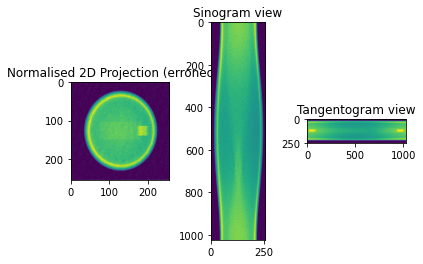

In [7]:
print ("Normalise projections using ToMoBAR software")
# normalise the data, the required data format is [detectorsX, Projections, detectorsY]
projData3D_norm = normaliser(projData3D_noisy, flatsSIM, darks=None, log='true', method='mean')

intens_max = 0.15*np.max(projData3D_norm)
sliceSel = 150
plt.figure() 
plt.subplot(131)
plt.imshow(projData3D_norm[:,sliceSel,:],vmin=0, vmax=intens_max)
plt.title('Normalised 2D Projection (erroneous)')
plt.subplot(132)
plt.imshow(projData3D_norm[sliceSel,:,:],vmin=0, vmax=intens_max)
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData3D_norm[:,:,sliceSel],vmin=0, vmax=intens_max)
plt.title('Tangentogram view')
plt.show()

FBP - Clean projection
FBP - Noisy projection
FBP - Split projection


/home/lqg38422/Desktop/n2i_tomobar/noise2inverse/fig.py:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/home/lqg38422/Desktop/n2i_tomobar/noise2inverse/fig.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


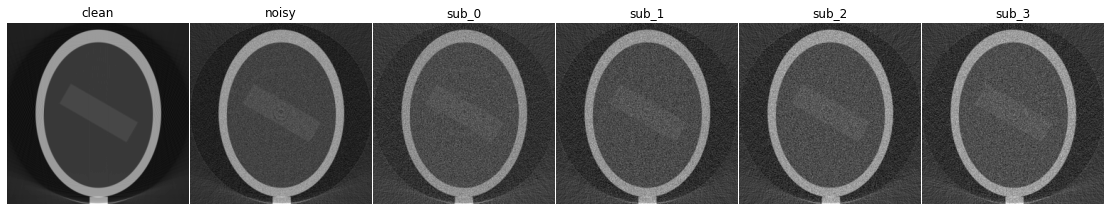

In [9]:
import numpy as np
import torch
from pathlib import Path
from noise2inverse import tiffs, noise, tomo, fig
from tomobar.methodsDIR import RecToolsDIR

num_splits = 4

RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # Center of Rotation (CoR) scalar (for 3D case only)
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')

# Reconstruct clean
print("FBP - Clean projection")
clean_rec = RectoolsDIR.FBP(projData3D_analyt) # FBP reconstruction
clean_rec = torch.tensor(clean_rec)
    
# Reconstruct noisy
print("FBP - Noisy projection")
noisy_rec = RectoolsDIR.FBP(projData3D_norm) # FBP reconstruction
noisy_rec = torch.tensor(noisy_rec)
    
# Reconstruct noisy splits
print("FBP - Split projection")
noisy_splits_rec = [] #/0, /1, /2, ...
for j in range(num_splits):
    RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # Center of Rotation (CoR) scalar (for 3D case only)
                    AnglesVec = angles_rad[j::num_splits], # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')
    sino_split = projData3D_norm[:, j::num_splits, :]
    rec = RectoolsDIR.FBP(sino_split)
    rec = torch.tensor(rec)
    noisy_splits_rec.append(rec)
noisy_splits_rec = torch.stack(noisy_splits_rec)
    
# Show results
slice_num = len(noisy_splits_rec[0]) // 2
slice_clean = clean_rec[slice_num,:,:]
slice_noisy = noisy_rec[slice_num,:,:]
slice_0 = noisy_splits_rec[0,slice_num,:,:]
slice_1 = noisy_splits_rec[1,slice_num,:,:]
slice_2 = noisy_splits_rec[2,slice_num,:,:]
slice_3 = noisy_splits_rec[3,slice_num,:,:]

fig.plot_imgs(
    clean=slice_clean,
    noisy=slice_noisy,
    sub_0=slice_0,
    sub_1=slice_1,
    sub_2=slice_2,
    sub_3=slice_3, 
    width=20.0,
)

In [10]:
torch.cuda.empty_cache() #before we start training

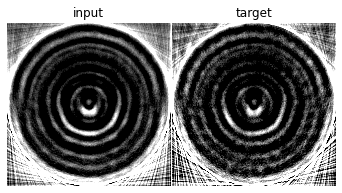

In [11]:
%matplotlib inline

import torch
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
from msd_pytorch import MSDRegressionModel
from torch.utils.data import DataLoader
from tqdm import tqdm

# Parameters
train_dir = Path("reconstructions")
output_dir = Path("weights")

num_splits = 4
strategy = "X:1"
epochs = 40 #100
batch_size = 16
multi_gpu = True
# Scale pixel intensities during training such that its values roughly occupy the range [0,1].
# This improves convergence.
data_scaling = 200

datasets = noisy_splits_rec.unsqueeze(2) #replace TiffDataset for np.array
#datasets = [TiffDataset(train_dir / f"{j}/*.tif") for j in range(num_splits)]
train_ds = Noise2InverseDataset(*datasets, strategy=strategy) #[256, 1, 256, 256] x4

fig.plot_imgs(
    input=train_ds[0][0].detach().squeeze(),
    target=train_ds[0][1].detach().squeeze(),
    vmin=0,
    vmax=0.008,
)

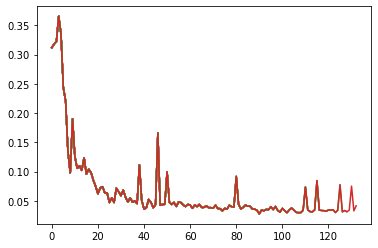

  9%|▉         | 6/64 [00:37<05:58,  6.19s/it]


KeyboardInterrupt: 

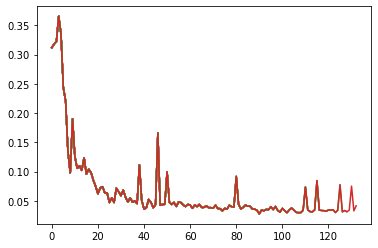

In [12]:
# Dataloader and network:
dl = DataLoader(train_ds, batch_size, shuffle=True,)
model = MSDRegressionModel(1, 1, 100, 1, parallel=multi_gpu)

output_dir.mkdir(exist_ok=True)

# The dataset contains multiple input-target pairs for each slice. 
# Therefore, we divide by the number of splits to obtain the effective number of epochs.
train_epochs = max(epochs // num_splits, 1)

# training loop
from IPython import display
loss_track = []
update_plot = 4
for epoch in range(train_epochs):
    print(f"EPOCH {epoch}: ")
    epoch_loss = []
    it = 0
    # Train
    for (inp, tgt) in tqdm(dl):
        inp = inp.cuda(non_blocking=True) * data_scaling
        tgt = tgt.cuda(non_blocking=True) * data_scaling

        # Do training step with masking
        model.output = model.net(inp)
        model.loss = model.criterion(model.output, tgt)
        # Loss
        epoch_loss.append(model.loss.item())
        loss_track.append(model.loss.item())
        if it % update_plot == 0:
            plt.plot(loss_track)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        model.optimizer.zero_grad()
        model.loss.backward()
        model.optimizer.step()
        it += 1
    #print(f"EPOCH {epoch} - Mean Loss: {np.mean(epoch_loss)}")
    # Save network 
    #model.save(output_dir / f"weights_epoch_{epoch}.torch", epoch)
    
model.save(output_dir / "weights.torch", epoch)
plt.plot(loss_track)

In [14]:
def normalise(im):
    return (im - im.min())/(im.max() - im.min())

256it [00:38,  6.62it/s]
/home/lqg38422/Desktop/n2i_tomobar/noise2inverse/fig.py:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/home/lqg38422/Desktop/n2i_tomobar/noise2inverse/fig.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


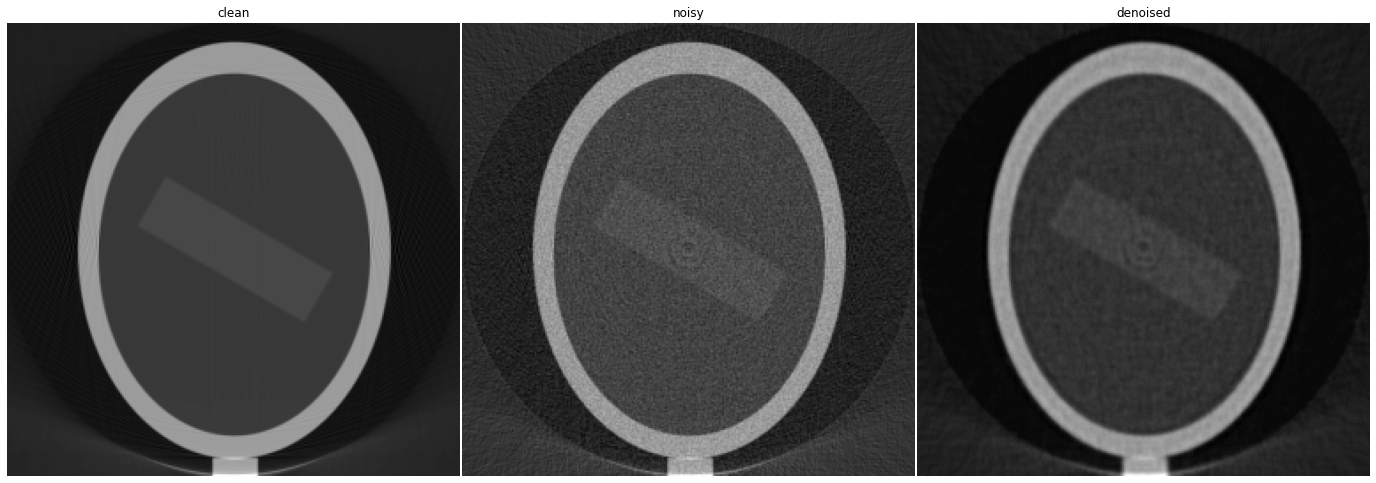

In [16]:
import tifffile
import torch
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
from msd_pytorch import MSDRegressionModel
from torch.utils.data import DataLoader
from tqdm import tqdm

# Parameters
input_dir = Path("reconstructions")
weights_path = Path("weights/weights.torch")
output_dir = Path("denoised")

num_splits = 4
strategy = "X:1"
batch_size = num_splits
multi_gpu = True
# Scale pixel intensities in the same way as during training.
data_scaling = 200

# Output dir
# output_dir.mkdir(exist_ok=True)

datasets = noisy_splits_rec.unsqueeze(2) #[TiffDataset(input_dir / f"{j}/*.tif") for j in range(num_splits)]
ds = Noise2InverseDataset(*datasets, strategy=strategy)

# Dataloader and network:
dl = DataLoader(ds, batch_size, shuffle=False,)
model = MSDRegressionModel(1, 1, 100, 1,parallel=True)
model.load(weights_path)

# Output tensor
output_tensor = []

# Put network in evaluation mode: this should be done when the network uses batch norm for instance.
model.net.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(dl)):
        inp, _ = batch     
        inp = inp.cuda() * data_scaling
        out = model.net(inp)
        # Take mean over batch dimension (splits):
        out = out.mean(dim=0) / data_scaling
        # Obtain 2D numpy array
        out_np = out.detach().cpu().numpy().squeeze()
        output_tensor.append(out_np)
        #out_path = str(output_dir / f"output_{i:05d}.tif")
        #tifffile.imsave(out_path, out_np)
output_tensor = np.array(output_tensor)
        
slice_num = len(clean_rec[0]) // 2 #50
denoised = output_tensor[slice_num,:,:] #tifffile.imread(f"./denoised/output_{str(slice_num).zfill(5)}.tif")
fig.plot_imgs(
    clean=normalise(clean_rec[slice_num,:,:]), #projData3D_analyt
    noisy=normalise(noisy_rec[slice_num,:,:]), #projData3D_norm
    denoised=normalise(denoised),
    vmin=0,
    vmax=1,
    width=25,
)

In [17]:
output_tensor.shape

(256, 256, 256)

In [21]:
slice_num

128

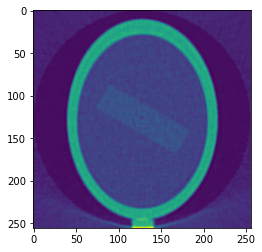

In [42]:
tmp = output_tensor[slice_num,:,:].copy()
plt.imshow(tmp)

In [61]:
clean_tmp = clean_rec[slice_num,:,:].numpy().copy()

In [63]:
clean_tmp.max(), clean_tmp.min(), clean_tmp.mean()

(1.2132584, -0.093885854, 0.18589558)

In [65]:
x, h = np.histogram(clean_tmp)

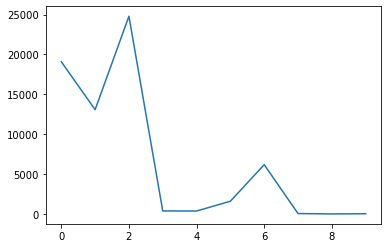

In [67]:
plt.plot(x)

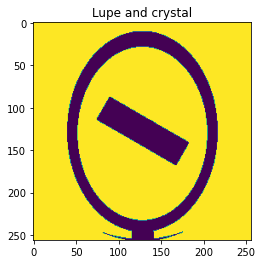

In [91]:
plt.figure()
plt.title("Lupe and crystal")
plt.imshow(clean_tmp <= 0.25)

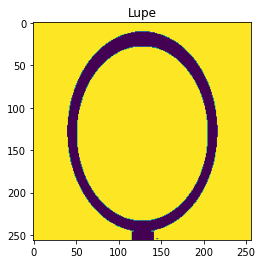

In [93]:
plt.figure()
plt.title("Lupe")
plt.imshow(clean_tmp <= 0.5)

In [237]:
from sklearn.cluster import KMeans

def km_clust(array, n_clusters):
    
    # Create a line array, the lazy way
    X = array.reshape((-1, 1))
    # Define the k-means clustering problem
    k_m = KMeans(n_clusters=n_clusters, n_init=4)
    # Solve the k-means clustering problem
    k_m.fit(X)
    # Get the coordinates of the clusters centres as a 1D array
    values = k_m.cluster_centers_.squeeze()
    # Get the label of each point
    labels = k_m.labels_
    return(values, labels)

In [242]:
values, labels = km_clust(clean_tmp, n_clusters = 5)

In [243]:
values = list(range(len(values)))

In [244]:
img_segm = np.choose(labels, values)
img_segm.shape = clean_tmp.shape

[Text(0, -50.0, ''),
 Text(0, 0.0, ''),
 Text(0, 50.0, ''),
 Text(0, 100.0, ''),
 Text(0, 150.0, ''),
 Text(0, 200.0, ''),
 Text(0, 250.0, ''),
 Text(0, 300.0, '')]

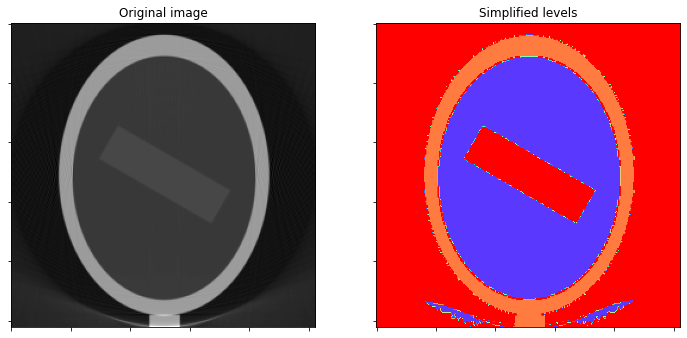

In [245]:
vmin = clean_tmp.min()
vmax = clean_tmp.max()

fig = plt.figure(1, figsize=(12,12))
# Plot the original image
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(clean_tmp,cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax1.set_title('Original image')
# Plot the simplified color image
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_segm, cmap=plt.cm.rainbow, vmin=vmin, vmax=vmax)
ax2.set_title('Simplified levels')
# Get rid of the tick labels
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
